In [7]:
!ls data

1045_Steel_Nital-etch-01.tif  1045_Steel_Nital-etch-06.tif
1045_Steel_Nital-etch-02.tif  1045_Steel_Nital-etch-07.tif
1045_Steel_Nital-etch-03.tif  20150911_1045_Nital_etch2.tif
1045_Steel_Nital-etch-04.tif  20150911_1045_Nital_etch.tif
1045_Steel_Nital-etch-05.tif


In [9]:
!head -5 data/1045_Steel_Nital-etch-01.tif

II*   Cτ��5"��-�71W<J�_;�AHWWbF=;�W_DJ��I;��)l�3&&�-2|�2|AFJW}1V�U&L��y���zp��C?:2.(1;8/(SYCF50IS_k��{kb\M6;�`8*;�:�M�E��c�g
#!#2��K{`s|����H!&3I+(+/..101*)+,**%''(()%)+/-,.,)(*-+*..))&t��Ю�qly{�RKJH<Sz�gQsk�P%isgDQL[FL�v�;';��xWKNB5-+,-,,03?*0./7I6//BL1?<4G<8?AspNWO_b.5H;,(=c�K/3,/=HQ@LkbL824<B?;;72;g���wG9VO�NCr��������`#"E;0)6;?RN=:UD�ZTL;.({}K736<9:6,-+*-*&(+())'%!,1!!8055641&*00.1/34449<5<26/-$+2*4k�ljG�dc:,Lu?6><6:CEA=62*'#%2CM�,ImD~#5�RRk`\*J0A94.%! !##%%%$''21,.0.477:>DBC;=868/+.--*-+)+-+)*),.,+020--01654/-VQ[XWg"!)(';)(5,.6�Y1+b1,(($ i=+))*#T,++))*+71'+*&+22542//)86..*F/V600lP]w�O <'#%*)$& 
nZk8WU>O6'@11H8@27P@:8iA;0wA3i?;aJ:2:S02@o=a5R3,L0**)/),S7S:2/01744=P53CHM[RR[IDJPTUW�\it?9.>;.LT~ޢA:0-*7��@�99XT{�`LI$�P�?�F{[o-HuI"�Pyz�iUhig�GobZ��-)�>P�PQQA" !!'#'&"a5A%4D`QIB/,-+++Z1DKM���xk4),).EH?^
+{�rOH~]�[ґ�8%+(0)$+74-,'+*&',',,4*/(&(+('''-,/0-),/7.%1��d{���QK`sySA>6:\��ST}�A!Qfy:A�mK-k�ashU�_BJP@8.)'),-+YS

In [1]:
import glob
import pytesseract
import PIL.Image
from toolz.curried import map, pipe, compose, get
import pandas
from skimage.measure import label, regionprops
import numpy as np

crop_cutoff = 960

ff = lambda *args: compose(*args[::-1])

crop = ff(
    PIL.Image.open,
    lambda image: (image.crop(box=(0, 0, image.size[0], crop_cutoff)),
                   image.crop(box=(0, crop_cutoff, image.size[0], image.size[1]))),

)

string_data = ff(
    lambda image: pytesseract.image_to_string(image),
    lambda string: string.split(),
    get([1, 3, -1]),
    lambda data: dict(scale=float(data[0].replace('pm', '')),
                      date=data[1],
                      time=data[2])
)

scale_pixels = ff(
    np.array,
    lambda data: data if len(data.shape) ==2 else data[...,0],
    lambda data: label(data, background=0),
    regionprops,
    get(1),
    lambda data: data.bbox[3] - data.bbox[1]
)

make_df = ff(
    glob.glob,
    sorted,
    map(lambda filename: (filename, crop(filename)[1])),
    map(lambda data: dict(filename=data[0],
                          scale_pixels=scale_pixels(data[1]),
                          **string_data(data[1]))),
    list,
    pandas.DataFrame
)

data = make_df('data/*.tif')
print(data)

        date                            filename  scale  scale_pixels  \
0  6/17/2015   data/1045_Steel_Nital-etch-01.tif   10.0           107   
1  6/17/2015   data/1045_Steel_Nital-etch-02.tif   10.0           161   
2  6/17/2015   data/1045_Steel_Nital-etch-03.tif   10.0           267   
3  6/17/2015   data/1045_Steel_Nital-etch-04.tif    1.0            80   
4  6/17/2015   data/1045_Steel_Nital-etch-05.tif    1.0            54   
5  6/17/2015   data/1045_Steel_Nital-etch-06.tif   10.0           161   
6  6/17/2015   data/1045_Steel_Nital-etch-07.tif   10.0           267   
7  9/11/2015   data/20150911_1045_Nital_etch.tif   10.0            54   
8  9/11/2015  data/20150911_1045_Nital_etch2.tif   10.0            54   

       time  
0  13:16:51  
1  13:20:17  
2  13:42:26  
3  13:52:11  
4  14:04:46  
5  14:06:17  
6  14:12:37  
7  10:08:55  
8  11:10:14  


data/1045_Steel_Nital-etch-01.tif


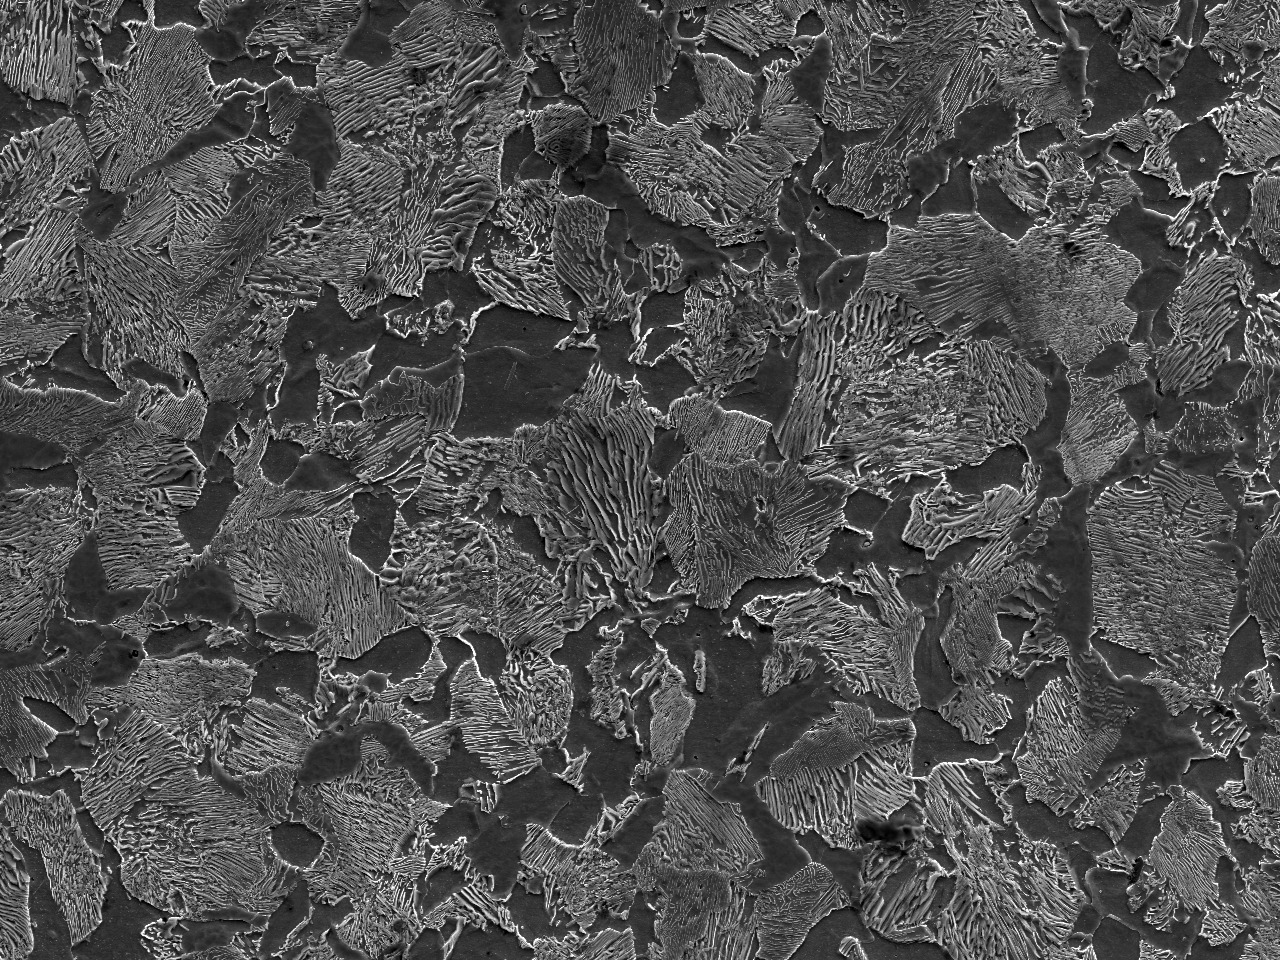

In [2]:

print(data.ix[0]['filename'])
crop(data.ix[0]['filename'])[0]

In [3]:
image = PIL.Image.open('data/1045_Steel_Nital-etch-01.tif')

In [4]:
image.size

(1280, 1024)

In [5]:
960 / 1024

0.9375

In [6]:
data['filename'][0]

'data/1045_Steel_Nital-etch-01.tif'